In [57]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def pull_nash_marathon_data(is_full=True, city='Nashville', year='2019'):
    full_in = '' if is_full else 'Half-'
    URL = 'https://www.runrocknroll.com/Events/' + city + '/The-Races/' + full_in + 'Marathon/' + year + '-Results'
    df_list = []
    row_shape, x = (1, 1)
    while row_shape > 0:    
        payload = {'page': str(x)}
        response = requests.post(URL, params=payload)        
        table_soup = bs(response.content, "html.parser").find(attrs={"class": "race-search-main"})
        df_page = pd.read_html(str(table_soup))[0]    
        row_shape = df_page.shape[0]
        df_list.append(df_page)
        x += 1   
    print('pulled ' + year + ' ' + str(is_full))
    return pd.concat(df_list)



In [5]:
##run pull function for Nashville races
fulls, halves = [], []
for yr in range(2016, 2020):
    fulls.append(pull_nash_marathon_data(is_full=True, city='Nashville', year=str(yr)))
    halves.append(pull_nash_marathon_data(is_full=False, city='Nashville', year=str(yr)))
print(str(len(fulls)) + ' ' + str(len(halves)))

pulled 2016 True
pulled 2016 False
pulled 2017 True
pulled 2017 False
pulled 2018 True
pulled 2018 False
pulled 2019 True
pulled 2019 False
4 4


In [6]:
## Add a column for how much of a marathon was run for calculating time/marathon

for f in fulls:
    f['Race'] = 1
for h in halves:
    h['Race'] = 0.5

In [69]:
all_lists = fulls + halves
all_races = pd.concat(all_lists, axis=0)
all_races.reset_index(inplace=True)
all_sorted = all_races.sort_values('Time', axis=0)

## Remove times for those who didn't finish or didn't have a time recorded
less_dnf_sorted = all_sorted.loc[all_sorted['Time'] != '00:00:00']

total_runner_years = less_dnf_sorted.shape[0]
## Take out duplicate runners, keeping their shortest race time 
## (which may be only a half-marathon if they ran both types)
no_dnf_dupes = less_dnf_sorted.drop_duplicates(subset=['Name'], keep='first')
runners_deduped = no_dnf_dupes.shape[0]
prop_duplicates = (total_runner_years - runners_deduped) / total_runner_years
y = 1 / (1 - prop_duplicates)
print('Average runner ran the race ' + str(round(y, 2)) + ' times.')

Average runner ran the race 1.24 times.


In [8]:
split_first_names = no_dnf_dupes.copy()
split_first_names['First Name'] = split_first_names['Name'].apply(lambda x: x.split(' ')[0])
print(split_first_names['First Name'])

57140    Roosevelt
57141        Lucas
72080         Nick
34848        Tyler
34849         Bill
           ...    
2946          Lynn
3457        Annaka
2948          Kate
2949     Gabrielle
2950       Valerie
Name: First Name, Length: 59619, dtype: object


In [9]:
no_dnf_dupes = split_first_names

In [10]:
split_last_names = no_dnf_dupes.copy()
split_last_names['Last Name'] = split_last_names['Name'].apply(lambda x: x.split(' ')[-1])
print(split_last_names['Last Name'])

57140                Cook
57141              Cotter
72080              French
34848             Andrews
34849              Martin
               ...       
2946     Gillespie-Chater
3457               Silver
2948              Mishkin
2949               Castro
2950               Bailey
Name: Last Name, Length: 59619, dtype: object


In [11]:
no_dnf_dupes = split_last_names

In [56]:
find_middle = no_dnf_dupes.copy()
find_middle['Middle'] = find_middle['Name'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1] != x.split(' ')[-1] else '')
have_middles = find_middle.loc[find_middle['Middle'].str.len() > 1]
print('Percent of Runners with middle names: ' + str(round((100 * have_middles.shape[0] / find_middle.shape[0]), 2)))

Percent of Runners with middle names: 1.95


In [12]:
def pct_has_char(df, char_array, col):
    instances = 0
    for char in char_array:
        instances += df.loc[df[col].str.contains(char, regex=False)].shape[0]
    return round(100 * (instances / df.shape[0]), 2)

def count_char(name_string, lower_char):
    instances = 0
    for letter in name_string:
        if letter == lower_char or letter.lower() == lower_char:
            instances += 1
        else:
            pass
    return instances

other = ['ã', '³', 'é', '¹', 'ç', 'ž', 'ñ', 'Â', '€', '˜', 'â', '™', '£', 'í', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

##How many runners have hyphenated Last Names?
print('Percent Hyphenated ' + str(pct_has_char(no_dnf_dupes, ['-'], 'Name')))

## ##How many runners have apostrophied Last Names?
print('Percent apostrophied ' + str(pct_has_char(no_dnf_dupes, ["'", "`", "’"], 'Name')))

print('Percent parenthesized ' + str(pct_has_char(no_dnf_dupes, ['(', '{', '['], 'Name')))

print('Percent with periods ' + str(pct_has_char(no_dnf_dupes, ['.'], 'Name')))

print('Percent with other characters ' + str(pct_has_char(no_dnf_dupes, other, 'Name')))

Percent Hyphenated 0.78
Percent apostrophied 0.38
Percent parenthesized 0.04
Percent with periods 0.17
Percent with other characters 0.07


In [13]:
##Discover how many First Names are also the Last Names of another runner
is_last = no_dnf_dupes.loc[no_dnf_dupes['First Name'].isin(no_dnf_dupes['Last Name'])].shape[0]
pct_is_last = round(100 * (is_last / no_dnf_dupes.shape[0]), 2)
print('Percent of First Names that are also Last Names: ' + str(pct_is_last))

Percent of First Names that are also Last Names: 39.3


In [14]:
def are_alpha(name_string):
    are_all_alpha = True
    for s in name_string:
        if (ord(s) >= 65 and ord(s) <= 90) or (ord(s) >= 97 and ord(s) <= 122) or (ord(s) == 32):
            pass
        else:
            are_all_alpha = False
            break
    return are_all_alpha

def spit_non_alpha(name_string):
    non_alphas = []
    for s in name_string:        
        if ((ord(s) >= 65 and ord(s) <= 90) or (ord(s) >= 97 and ord(s) <= 122) or (ord(s) == 32)):
            pass
        else:
            non_alphas.append(s)
    return non_alphas       

In [15]:
non_alpha_names = no_dnf_dupes.loc[~no_dnf_dupes['Name'].apply(lambda x: are_alpha(x))]
print(non_alpha_names)

       index Overall    Bib                   Name      Time  Race  \
72137      7      58  16681     Arturo Cruz-Tucker  01:28:06   0.5   
72146     16      67  17944         Warren O’neill  01:28:55   0.5   
34890     17      43   4019       Jesse Zaro-Moore  01:29:23   0.5   
72161      6      82   1278   Edward Stuart-Bourne  01:30:26   0.5   
12527      8     110   1333         Adam O'Donnell  01:31:01   0.5   
...      ...     ...    ...                    ...       ...   ...   
11619     11    2012  31665     Anne-Marie Balzano  06:19:53   1.0   
11622     14    2015  32794           Julie O'Neal  06:20:57   1.0   
2884       9    2893  26202  Pamela Daniels-Halisi  06:23:18   1.0   
2937      12    2947  27121    Nicholas D'Agostino  06:37:02   1.0   
2946      21    2956  27374  Lynn Gillespie-Chater  06:44:43   1.0   

       First Name         Last Name  
72137      Arturo       Cruz-Tucker  
72146      Warren           O’neill  
34890       Jesse        Zaro-Moore  
72161  

In [16]:
less_dnf_copy = no_dnf_dupes.copy()
less_dnf_copy['A Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'a'))
less_dnf_copy['E Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'e'))
less_dnf_copy['I Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'i'))
less_dnf_copy['O Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'o'))
less_dnf_copy['U Count'] = no_dnf_dupes['Name'].apply(lambda x: count_char(x, 'u'))
less_dnf_copy['Total Characters'] = no_dnf_dupes['Name'].apply(lambda x: len(x))

In [17]:
no_dnf_dupes = less_dnf_copy
no_dnf_dupes.head()

,index,Overall,Bib,Name,Time,Race,First Name,Last Name,A Count,E Count,I Count,O Count,U Count,Total Characters
57140,0,1,103,Roosevelt Cook,01:09:25,0.5,Roosevelt,Cook,0,2,0,4,0,14
57141,1,2,107,Lucas Cotter,01:09:51,0.5,Lucas,Cotter,1,1,0,1,1,12
72080,0,1,31,Nick French,01:10:03,0.5,Nick,French,0,1,1,0,0,11
34848,0,1,202,Tyler Andrews,01:10:58,0.5,Tyler,Andrews,1,2,0,0,0,13
34849,1,2,204,Bill Martin,01:11:25,0.5,Bill,Martin,1,0,2,0,0,11


In [18]:
no_dnf_dupes['Time Delta'] = pd.to_timedelta(no_dnf_dupes['Time'])

In [19]:
no_dnf_dupes['Time per Full'] = no_dnf_dupes['Time Delta'] / no_dnf_dupes['Race']

In [20]:
no_dnf_dupes['Total Vowels'] = no_dnf_dupes['A Count'] + no_dnf_dupes['E Count'] + no_dnf_dupes['I Count'] + no_dnf_dupes['O Count'] + no_dnf_dupes['U Count']
no_dnf_dupes['Vowels Rate'] = no_dnf_dupes['Total Vowels'] / no_dnf_dupes['Total Characters']

In [21]:
no_dnf_dupes['Starts With'] = no_dnf_dupes['Name'].apply(lambda x: x[0].upper())

  Starts With  Overall
0           J     7427
1           M     6167
2           A     5695
3           K     5215
4           C     4926


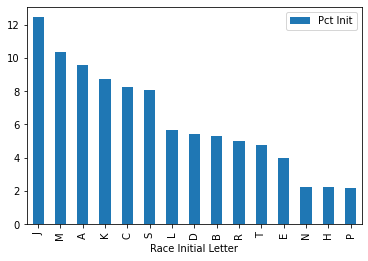

In [22]:
race_names_count = pd.DataFrame(no_dnf_dupes.groupby(['Starts With']).count()['Overall'])
race_names_count = race_names_count.sort_values('Overall', ascending=False).reset_index()
race_names_count['Grand Total'] = race_names_count['Overall'].sum()
race_names_count.rename(columns={'Overall': 'Sum Names', 'Starts With': 'Race Initial Letter'}, inplace=True)

race_names_count['Pct Init'] = 100 * race_names_count['Sum Names'] / race_names_count['Grand Total']
race_names_short = race_names_count.head(15)
race_names_short.plot.bar('Race Initial Letter','Pct Init')

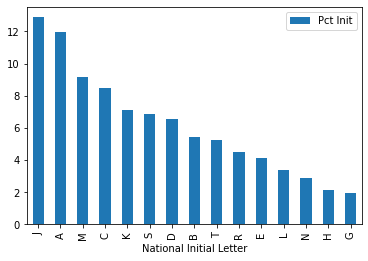

In [23]:
## DL baby names from 1995 to compare them to race names
names_df_list = []
names_df_list.append(pd.read_csv('../../assets/yob1994.txt', names=['Baby Name', 'Gender', 'Number']))
names_df_list.append(pd.read_csv('../../assets/yob1995.txt', names=['Baby Name', 'Gender', 'Number']))
names_df_list.append(pd.read_csv('../../assets/yob1996.txt', names=['Baby Name', 'Gender', 'Number']))
names_df_94_96 = pd.concat(names_df_list)
names_df_94_96['Init'] = names_df_94_96['Baby Name'].apply(lambda x: x[0].upper())

names_summed = names_df_94_96.groupby(by='Init')['Number'].agg(['sum']).sort_values(by=('sum'), ascending=False).reset_index()
names_summed.rename(columns={'Init': 'National Initial Letter'}, inplace=True)
names_summed['Grand Total'] = names_summed['sum'].sum()
names_summed['Pct Init'] = 100 * names_summed['sum'] / names_summed['Grand Total']
names_summed_short = names_summed.head(15)
names_summed_short.plot.bar('National Initial Letter','Pct Init')


In [24]:
time_correct_df = no_dnf_dupes.astype({'Time per Full': 'timedelta64[m]'})

In [25]:
time_correct_df.head()

,index,Overall,Bib,Name,Time,Race,First Name,Last Name,A Count,E Count,I Count,O Count,U Count,Total Characters,Time Delta,Time per Full,Total Vowels,Vowels Rate,Starts With
57140,0,1,103,Roosevelt Cook,01:09:25,0.5,Roosevelt,Cook,0,2,0,4,0,14,01:09:25,138.0,6,0.428571,R
57141,1,2,107,Lucas Cotter,01:09:51,0.5,Lucas,Cotter,1,1,0,1,1,12,01:09:51,139.0,4,0.333333,L
72080,0,1,31,Nick French,01:10:03,0.5,Nick,French,0,1,1,0,0,11,01:10:03,140.0,2,0.181818,N
34848,0,1,202,Tyler Andrews,01:10:58,0.5,Tyler,Andrews,1,2,0,0,0,13,01:10:58,141.0,3,0.230769,T
34849,1,2,204,Bill Martin,01:11:25,0.5,Bill,Martin,1,0,2,0,0,11,01:11:25,142.0,3,0.272727,B


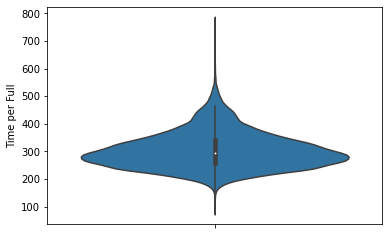

In [65]:
sns.violinplot(y='Time per Full', data=time_correct_df)

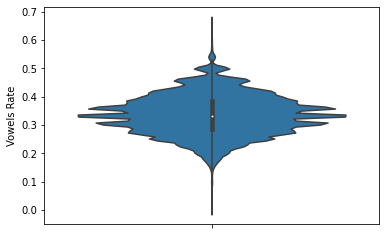

In [67]:
sns.violinplot(y='Vowels Rate', data=time_correct_df)

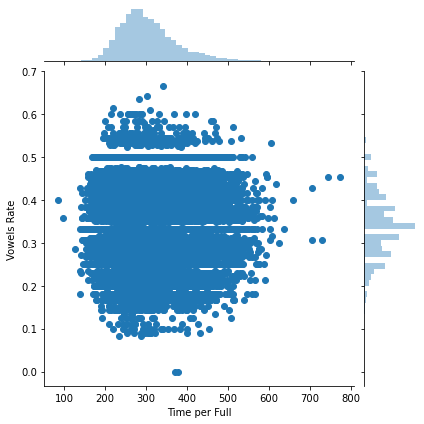

In [68]:
sns.lmplot(x='Time per Full', y='Vowels Rate', data=time_correct_df, line_kws={'color': 'red'})

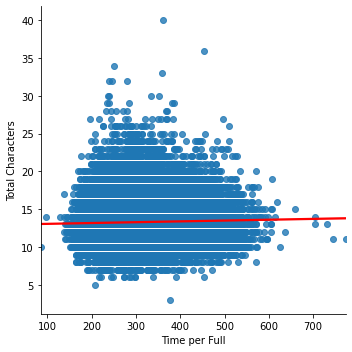

In [62]:
sns.lmplot(x='Time per Full', y='Total Characters', data=time_correct_df, line_kws={'color': 'red'})

In [ ]:
sum_vowels = [time_correct_df['A Count'].sum(), time_correct_df['E Count'].sum(), time_correct_df['I Count'].sum(), time_correct_df['O Count'].sum(), time_correct_df['U Count'].sum()]
new_df = pd.DataFrame({'Vowel Sums': sum_vowels, 'Vowels': ['A', 'E', 'I', 'O', 'U']})


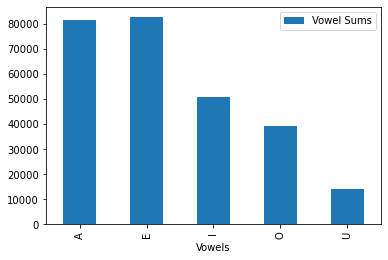

In [45]:
new_df.plot.bar('Vowels','Vowel Sums')